# 06 Model 1 - Decision Tree

# Contents

1. Introduction
2. Defining the Machine Learning model pipeline
3. Baseline Model accuracy - Train set
4. Coarse analysis
5. RandomizedSearchCV
6. Accuracy after hyperparameter optimisation
7. Model evaluation
8. Conclusion and next steps

# 1. Introduction

In this notebook, we aim to optimise the hyperparameters of a Decision Tree classifier using data that has already been scaled. 

We previously determined that the optimal number of PCA components for dimensionality reduction is 30. However, for this project we care about interpretability, which we will not gain using PCA. We also know that Decision Trees select the 'best feature for splitting at each node based on information gain. Features with higher information gain are considered more important for splitting, thus aiding in feature selection.


Key objectives:

1. To ensure robust model evaluation, we will employ cross-validation throughout our tuning process.

2. We begin with a coarse analysis of hyperparameters using the resampled training data, X_train_resampled and y_train_resampled. Initially, we will explore the effects of two key hyperparameters: max_depth and min_samples_leaf. This analysis will help us identify a suitable range of values for these parameters, setting the stage for more precise tuning through Randomized Search Cross-Validation.

3. Following the coarse analysis, we will implement Randomized Search CV to systematically sample from a defined hyperparameter distribution.

Let's begin by importing necessary libraries:

In [32]:
import time

In [35]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from tempfile import mkdtemp
from sklearn.feature_selection import RFE


And let's read in our saved preprocessed variables for traina nd test, which have already been resampled, scaled in preparation for advanced modelling:

In [33]:
import joblib

# Load the saved data
X_train_resampled_df = joblib.load('../preprocessed_variables/X_train_resampled_df.pkl')
X_test_scaled_df = joblib.load('../preprocessed_variables/X_test_scaled_df.pkl')
y_train_resampled = joblib.load('../preprocessed_variables/y_train_resampled.pkl')
y_test = joblib.load('../preprocessed_variables/y_test.pkl')

# Verify the loaded data
print(X_train_resampled_df.shape, y_train_resampled.shape)
print(X_test_scaled_df.shape, y_test.shape)


(370990, 325) (370990,)
(88597, 325) (88597,)


The shape of our train and test data is as anticipated.

# 2. Defining the Machine Learning model pipeline:

Let's begin by setting up our machine learning pipeline with the Decision Tree Classifier. As discussed earlier, we will not be applying dimensionality reduction, but a key part of our model inrerpretation after all of this will be analysing feature importance coming out from this model.

In [36]:
# Define the pipeline
cachedir = mkdtemp()
estimators = [
    # ('pca', PCA(n_components=30)),  # Apply PCA with 30 components
    ('model', DecisionTreeClassifier())  # Decision Tree Classifier
]
pipe = Pipeline(estimators, memory=cachedir)

# 3. Baseline model accuracy - Train set

Let's the fit the Decision Tree model **without any cross validation, or hyperparameter optimisation** to understand how this performs on our train data:

In [37]:
# Fit the pipeline on the training data
pipe.fit(X_train_resampled_df, y_train_resampled)

Pipeline(memory='/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/tmpbs7u6pln',
         steps=[('model', DecisionTreeClassifier())])

Running this baseline decision tree model, without any hyperparameter optimisation, let's evaluate the training accuracy of our initial model:

In [38]:
# Compute training accuracy
baseline_train_accuracy_dt = pipe.score(X_train_resampled_df, y_train_resampled)
print(f"Training Accuracy for DT Model: {baseline_train_accuracy_dt:.8f}")

Training Accuracy for DT Model: 1.00000000


 Compared to our logistic regression model, optimised through backwards selection, our training accuracy is significantly higher - reaching 100%.
 
 * This suggests extreme overfitting, which Decision Trees are prone to - so we need to address this.
 * However, we're yet to learn how this model performs on unseen data - so let's proceed with our process of hyperparamter optimisation before returning to our **model evaluation**.

# 4. Coarse analysis

The purpose of coarse analysis in our modelling process is to perform an initial exploration of hyperparameters to understand their impact on model performance. 

By systematically varying key hyperparameters (like `max_depth`, `min_samples_leaf`, `min_samples_split`, and `max_features`), we aim to identify which ranges of these parameters lead to better model accuracy and generalisation. 

This helps:

* Determine which hyperparameters warrant deeper exploration/finetuning through methods like RandomizedSearchCV 

* Avoid Overfitting

During this process, we employ 5-fold cross validation:

* 5-fold cross-validation strikes a good balance between bias and variance. 

* It provides a more reliable estimate of model performance than a single train-test split, averaged to produce a single estimate of the model's performance.

**We're going to explore 3 different hyperparameters in turn:**

## (a) Exploring `max_depth`

This hyperparameter sets the maximum number of levels (or splits) the tree can have. A shallow tree (small max_depth) has fewer splits, while a deeper tree (larger max_depth) can capture more complex patterns.

Setting max_depth to 2 for the DecisionTreeClassifier.
Setting max_depth to 4 for the DecisionTreeClassifier.
Setting max_depth to 6 for the DecisionTreeClassifier.
Setting max_depth to 8 for the DecisionTreeClassifier.
Setting max_depth to 10 for the DecisionTreeClassifier.
Setting max_depth to 12 for the DecisionTreeClassifier.
Setting max_depth to 15 for the DecisionTreeClassifier.
Setting max_depth to 20 for the DecisionTreeClassifier.
Setting max_depth to 30 for the DecisionTreeClassifier.


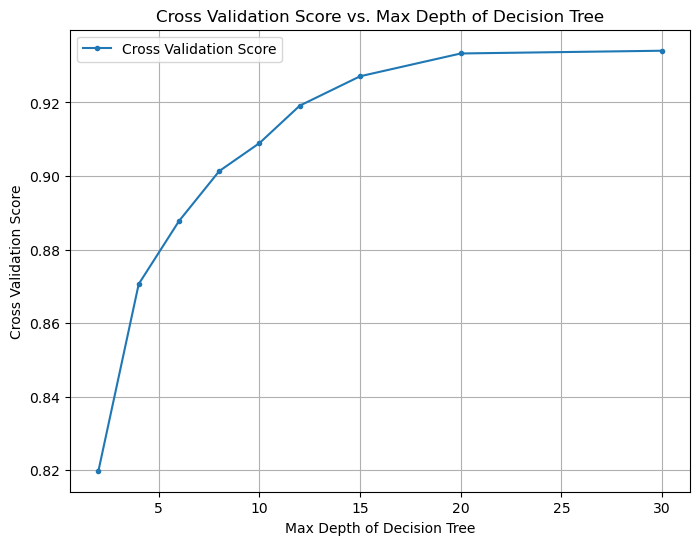

In [39]:
# Coarse analysis for max_depth
max_depth_range = np.array([2, 4, 6, 8, 10, 12, 15, 20, 30])
cross_validation_scores = []

for max_depth in max_depth_range:
    pipe.set_params(model__max_depth=max_depth)
    print(f"Setting max_depth to {max_depth} for the DecisionTreeClassifier.")
    cv_score = np.mean(cross_val_score(pipe, X_train_resampled_df, y_train_resampled, cv=5))  # 5-fold cross-validation
    cross_validation_scores.append(cv_score)

# Plotting the cross-validation scores for max_depth
plt.figure(figsize=(8, 6))
plt.plot(max_depth_range, cross_validation_scores, label="Cross Validation Score", marker='.')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Cross Validation Score')
plt.title('Cross Validation Score vs. Max Depth of Decision Tree')
plt.grid(True)
plt.legend()
plt.show()

Let's get the value for max_depth with the max cross-validation score:

In [40]:
best_index = np.argmax(cross_validation_scores)
best_max_depth = max_depth_range[best_index]
print(f"We get the maximum cross-validation score when we set a max_depth of: {best_max_depth}")

We get the maximum cross-validation score when we set a max_depth of: 30


This will be very helpful for our RandomizedSearchCV later on. However, we might want to consider values beyond 30 to understand the impact of tuning this on our accuracy.

## (b) Exploring `min_samples_leaf`

This hyperparameter sets a threshold for the minimum number of training samples that must be present in a leaf node (the terminal nodes of the tree).

Setting min_samples_leaf to 5 for the DecisionTreeClassifier.
Setting min_samples_leaf to 10 for the DecisionTreeClassifier.
Setting min_samples_leaf to 15 for the DecisionTreeClassifier.
Setting min_samples_leaf to 20 for the DecisionTreeClassifier.
Setting min_samples_leaf to 30 for the DecisionTreeClassifier.
Time to run coarse analysis: 252.7425 seconds


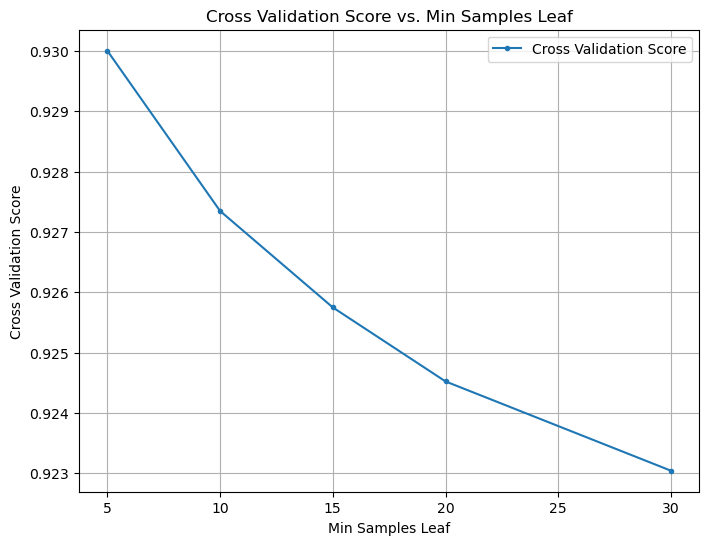

In [41]:
# Start the timer
start_time = time.time()

# Coarse analysis for min_samples_leaf
min_samples_leaf_range = np.array([5, 10, 15, 20, 30])
cross_validation_scores = []

for min_samples_leaf in min_samples_leaf_range:
    pipe.set_params(model__min_samples_leaf=min_samples_leaf)
    print(f"Setting min_samples_leaf to {min_samples_leaf} for the DecisionTreeClassifier.")
    cv_score = np.mean(cross_val_score(pipe, X_train_resampled_df, y_train_resampled, cv=5))  # 5-fold cross-validation
    cross_validation_scores.append(cv_score)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Time to run coarse analysis: {elapsed_time:.4f} seconds")

# Plotting the cross-validation scores for min_samples_leaf
plt.figure(figsize=(8, 6))
plt.plot(min_samples_leaf_range, cross_validation_scores, label="Cross Validation Score", marker='.')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Cross Validation Score')
plt.title('Cross Validation Score vs. Min Samples Leaf')
plt.grid(True)
plt.legend()
plt.show()

Let's get the value for min_samples_leaf with the max cross-validation score:

In [42]:
best_index = np.argmax(cross_validation_scores)
best_min_samples_leaf = min_samples_leaf_range[best_index]
print(f"We get the maximum cross-validation score when we set a min_samples_leaf of: {best_min_samples_leaf}")

We get the maximum cross-validation score when we set a min_samples_leaf of: 5


However, as we can see above in the plot, this suggests we need to consider ranges closer to 5 - potentially even lower than 5 when we conduct a RandomizedSearchCV.

## (c) Exploring `max_features`

This hyperparameter specifies the maximum number of features to consider when looking for the best split at each node. It controls how many features are evaluated for each split, impacting the complexity and diversity of the model.

Setting max_features to sqrt for the DecisionTreeClassifier.
Setting max_features to log2 for the DecisionTreeClassifier.
Setting max_features to 0.5 for the DecisionTreeClassifier.
Setting max_features to 0.8 for the DecisionTreeClassifier.
Time to run coarse analysis: 72.2323 seconds


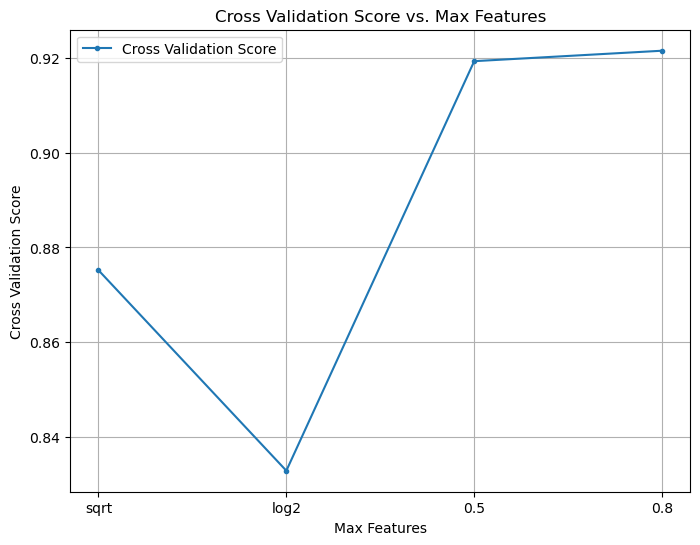

In [43]:
# Start the timer
start_time = time.time()

#set range of options - 0.5 means the decision tree will consider 50% of the features at each split.
max_features_options = ['sqrt', 'log2', 0.5, 0.8] 
cross_validation_scores_features = []

for max_features in max_features_options:
    pipe.set_params(model__max_features=max_features)
    print(f"Setting max_features to {max_features} for the DecisionTreeClassifier.")
    cv_score = np.mean(cross_val_score(pipe, X_train_resampled_df, y_train_resampled, cv=5))
    cross_validation_scores_features.append(cv_score)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Time to run coarse analysis: {elapsed_time:.4f} seconds")

# Plotting the cross-validation scores for max_features
plt.figure(figsize=(8, 6))
plt.plot(max_features_options, cross_validation_scores_features, label="Cross Validation Score", marker='.')
plt.xlabel('Max Features')
plt.ylabel('Cross Validation Score')
plt.title('Cross Validation Score vs. Max Features')
plt.grid(True)
plt.legend()
plt.show()

Let's get the value for max_features with the max cross-validation score:

In [44]:
best_index = np.argmax(cross_validation_scores_features)
best_max_features = max_features_options[best_index]
print(f"We get the maximum cross-validation score when we set max_features of: {best_max_features}")

We get the maximum cross-validation score when we set max_features of: 0.8


Again, we can use this to inform our RandomisedSearchCV parameters:

# 5. Using RandomisedSearchCV to hone in on optimisation parameters

RandomizedSearchCV is a technique used to find the best hyperparameters by randomly selecting combinations of hyperparameters from a predefined range and testing each combination to see which works best.

Given our results from the coarse analysis above, we can use a combination of specific values and ranges. For example, based on some of our plots, we know that certain values are promising (such as 30 for the 'max_depth\ hyperparameter), and can include them explicitly. However, we might use a range for others where we're still uncertain / exploring.

This time, we will also add another hyperparameter which we didn't finetune during our coarse analysis: `min_samples_split`

### Now, let's implement RandomizedSearchCV

In [45]:
from tqdm import tqdm

In [46]:
from sklearn.model_selection import RandomizedSearchCV

# Define a focused hyperparameter distribution based on coarse analysis results
param_distributions = {
    'model__max_depth': range(25,35),                # Based on coarse analysis for max_depth
    'model__min_samples_leaf': [3, 4, 5, 6, 7],         # Based on coarse analysis for min_samples_leaf
    'model__min_samples_split': [5, 10, 15, 20],     # Adding a new parameter to optimise
    'model__max_features': [0.6, 0.75, 0.8, 0.85 ]     # Based on coarse analysis for max_features
}

# Initialize RandomizedSearchCV with 5-fold cross-validation and a specified number of iterations
random_search = RandomizedSearchCV(
    estimator=pipe, 
    param_distributions=param_distributions, 
    n_iter=35,  # Number of parameter settings to sample
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Output details
    random_state=42,  # Ensure reproducibility
    n_jobs=8  # Use 8 cores for parallel processing
)

# Total number of fits = n_iter * cv
total_fits = random_search.n_iter * random_search.cv
print(f"\nTotal number of fits expected: {total_fits}")

# Start the timer to track the fitting time
start_time = time.time()

# Print message before starting the fitting process
print("\nStarting RandomizedSearchCV...")

# Fit RandomizedSearchCV to the training data, to yield the best model
best_model_DT = random_search.fit(X_train_resampled_df, y_train_resampled)

# End the timer and print elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nRandomizedSearchCV completed in {elapsed_time:.2f} seconds.")

# Retrieve best parameters, best score, and best estimator object
best_params_DT = best_model_DT.best_params_
best_score_DT = best_model_DT.best_score_
best_estimator_DT = best_model_DT.best_estimator_

# Print out best results
print("\nRandomizedSearchCV Results:")
print(f'Best Parameters: {best_params_DT}')
print(f'Best Cross-Validation Score: {best_score_DT:.4f}')
print(f'Best Estimator Object: {best_estimator_DT}')


Total number of fits expected: 175

Starting RandomizedSearchCV...
Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] END model__max_depth=33, model__max_features=0.75, model__min_samples_leaf=4, model__min_samples_split=20; total time=  24.1s
[CV] END model__max_depth=33, model__max_features=0.75, model__min_samples_leaf=4, model__min_samples_split=20; total time=  24.3s
[CV] END model__max_depth=33, model__max_features=0.8, model__min_samples_leaf=7, model__min_samples_split=5; total time=  25.0s
[CV] END model__max_depth=33, model__max_features=0.8, model__min_samples_leaf=7, model__min_samples_split=5; total time=  25.1s
[CV] END model__max_depth=33, model__max_features=0.75, model__min_samples_leaf=4, model__min_samples_split=20; total time=  25.2s
[CV] END model__max_depth=33, model__max_features=0.8, model__min_samples_leaf=7, model__min_samples_split=5; total time=  25.3s
[CV] END model__max_depth=33, model__max_features=0.8, model__min_samples_leaf=7, model__m

This outputs our 'best parameters' found by RandomizedSearchCV, and very helpful also outputs the best estimator object which we can now use to evaluate performance.

## Save the 'best model' results from RandomizedSearch CV

In [47]:
# Save the RandomizedSearchCV object (which includes best parameters, score, and estimator)
joblib.dump(best_model_DT, '../models/best_model_DT.pkl')

['../models/best_model_DT.pkl']

In [54]:
# Save the RandomizedSearchCV object (which includes best parameters, score, and estimator)
joblib.dump(best_estimator_DT, '../models/best_estimator_DT.pkl')
# Save the RandomizedSearchCV object (which includes best parameters, score, and estimator)
joblib.dump(best_params_DT, '../models/best_params_DT.pkl')

['../models/best_params_DT.pkl']

# 6. Accuracy after hyperparameter optimisation

In [48]:
# import joblib
# best_model_dt = joblib.load('../models/best_model_DT.pkl')

In [49]:
# Compute training accuracy
train_accuracy_dt = best_estimator_DT.score(X_train_resampled_df, y_train_resampled)
print(f"Training Accuracy for Decision Tree Model: {train_accuracy_dt:.8f}")

Training Accuracy for Decision Tree Model: 0.96675113


In [50]:
# Evaluate the best model on the test data
test_accuracy_dt = best_estimator_DT.score(X_test_scaled_df, y_test)
print(f"Test Accuracy for Decision Tree Model: {test_accuracy_dt:.8f}")

Test Accuracy for Decision Tree Model: 0.89922909


Let's visualise these results in more detail:

# 7. Model evaluation

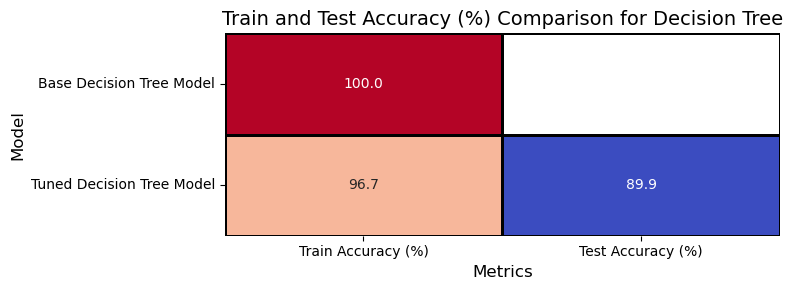

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Decision tree accuracy data
accuracy_data_dt = {
    'Train Accuracy (%)': [baseline_train_accuracy_dt * 100, train_accuracy_dt * 100],  # Multiply by 100 to get percentage
    'Test Accuracy (%)': [np.nan, test_accuracy_dt * 100]  # Only the tuned model has test accuracy
}

# Create a DataFrame for decision tree accuracy
accuracy_df_dt = pd.DataFrame(accuracy_data_dt, index=['Base Decision Tree Model', 'Tuned Decision Tree Model'])

# Create a mask for the missing (NaN) values
mask_dt = accuracy_df_dt.isna()

# Plot a heatmap with a mask to hide NaN values
plt.figure(figsize=(8, 3))
sns.heatmap(accuracy_df_dt, annot=True, fmt='.1f', cmap="coolwarm", cbar=False, linewidths=1, linecolor='black', mask=mask_dt)

# Set labels and title
plt.title("Train and Test Accuracy (%) Comparison for Decision Tree", fontsize=14)
plt.ylabel("Model", fontsize=12)
plt.xlabel("Metrics", fontsize=12)

plt.tight_layout()
plt.show()


### Comments on Train/Test accuracy:

So whilst our training accuracy decreased from our baseline Decision Tree, we can see we got a good test accuracy of ~90%. Both of which are higher than our original logistic regression model.

We can also generate the classification report for our Decision Tree:

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Make predictions on the test set
y_test_pred = best_estimator_DT.predict(X_test_scaled_df)

# Confusion matrix and classification report for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)

# Print evaluation metrics
print(f'Training Accuracy: {train_accuracy_dt:.2f}')
print(f'Test Accuracy: {test_accuracy_dt:.2f}')
print('Confusion Matrix (Test Set):')
print(conf_matrix)
print('Classification Report (Test Set):')
print(class_report)


Training Accuracy: 0.97
Test Accuracy: 0.90
Confusion Matrix (Test Set):
[[ 4577  4522]
 [ 4406 75092]]
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      9099
           1       0.94      0.94      0.94     79498

    accuracy                           0.90     88597
   macro avg       0.73      0.72      0.73     88597
weighted avg       0.90      0.90      0.90     88597



Here's what we can learn from this classification report:

1. Class 0 (Low Satisfaction):

* Precision: 0.51 – Of all the predictions for class 0, 51% were correct.
* Recall: 0.50 – The model correctly identified 50% of the actual class 0 instances.
* F1-Score: 0.51 – The balance between precision and recall is moderate for this class, indicating potential difficulty in distinguishing low satisfaction instances.

2. Class 1 (High Satisfaction):

* Precision: 0.94 – The model is highly accurate in predicting high satisfaction, with 94% of predictions for class 1 being correct.
* Recall: 0.94 – The model also successfully identifies 94% of the true high satisfaction cases.
* F1-Score: 0.94 – Strong overall performance in predicting class 1.

Displaying the confusion matrix can shed more light on where the model struggles with dealing instances of class 0, i.e., individuals with 'Low Satisfaction':

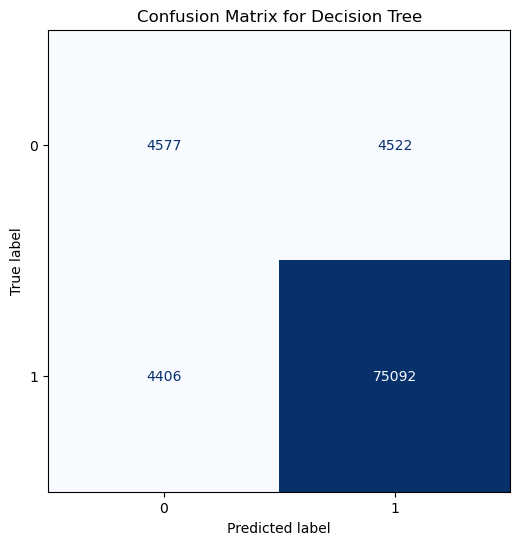

In [55]:
# Display the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay


fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Confusion Matrix for Decision Tree')
plt.grid(False)
plt.show()

## Key takeaways:

The confusion matrix confirms findings from the classification report:

* High True Positives (75,092): The model is doing an excellent job at predicting class 1 (high satisfaction), with the majority of true class 1 instances being correctly identified, confirming the high precision and recall for class 1 as indicated in the classification report.

* Moderate True Negatives (4,577): The model performs moderately well at correctly identifying class 0 (low satisfaction), but it could be better, especially given that the number of false positives (4,522) is nearly equal to the number of true negatives.

* High False Positives and False Negatives: The model struggles to distinguish class 0 (low satisfaction), as seen in the relatively high number of false positives (4522) and false negatives (4406). This contributes to the lower precision and recall for class 0.


# 8. Conclusion and next steps

The confusion matrix highlights the imbalance in our Decision Tree's performance across the two classes. The model is highly confident in predicting high satisfaction but struggles with low satisfaction. The high number of false positives and false negatives for class 0 shows that the model is misclassifying many of these instances, leading to lower recall for the low satisfaction class and explaining the lower precision for class 0.

This reinforces the need to explore further tuning, or potentially different models, to improve recall for class 0 (low satisfaction) while maintaining high performance for class 1 (high satisfaction).

To address these limitations and further enhance the model’s predictive performance, we will now explore the **Random Forest** model. Random Forest, as an ensemble method, is capable of reducing overfitting by aggregating the results of multiple decision trees, thus improving both **generalisation** and **classification performance**. It also provides robust insights into **feature importance**, which can help further refine our feature selection process.

By combining the strength of multiple trees, we expect the Random Forest model to better balance precision and recall across both classes, especially for identifying low satisfaction (which is the minority sample in the test data)

[Proceed to Model 3: Random Forest](../notebooks/07%20Model%203%20-%20Random%20Forest.ipynb)